# Assignment 2: Depth Estimation From Stereo and Video

In [1]:
import cv2 
import math
import numpy as np
import gco
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
%matplotlib inline

## Part 1: Noise Removal

In [2]:
def dist(c1, c2):
    dist = np.sum(np.absolute(c1 - c2))/3
    return dist

def add_weight(unary_cost, node, dist_src, dist_sink):
    unary_cost[node] = [dist_src, dist_sink]
    return unary_cost
    
def add_edge(edges, edge_weights, node, next_node, cost_1, cost_2):
    edges.append([node, next_node])
    edge_weights.append(cost_1)
    return edges, edge_weights

def construct_graph(img, m_lambda):
    height, width, colors = img.shape
    
    idxs = np.arange(height*width).reshape(height, width)
    edges = []
    edge_weights = []
    unary_cost = np.zeros([height*width, 2])
    
    for x in range(height):
        for y in range(width):
            c = img[x, y]
            node = idxs[x, y]

            # data term:
            unary_cost = add_weight(unary_cost, node, dist(SOURCE_COLOR,c), dist(SINK_COLOR,c))

            # prior term: start
            if x + 1 < height:
                next_node = idxs[x+1, y] # the right neighbor
                edges, edge_weights = add_edge(edges, edge_weights, node, next_node, m_lambda, m_lambda)
                
            if y + 1 < width:
                next_node = idxs[x, y+1] # the below neighbor
                edges, edge_weights = add_edge(edges, edge_weights, node, next_node, m_lambda, m_lambda)
            # prior term: end
            
    return np.asarray(edges), np.asarray(edge_weights), unary_cost

(573, 769, 3)


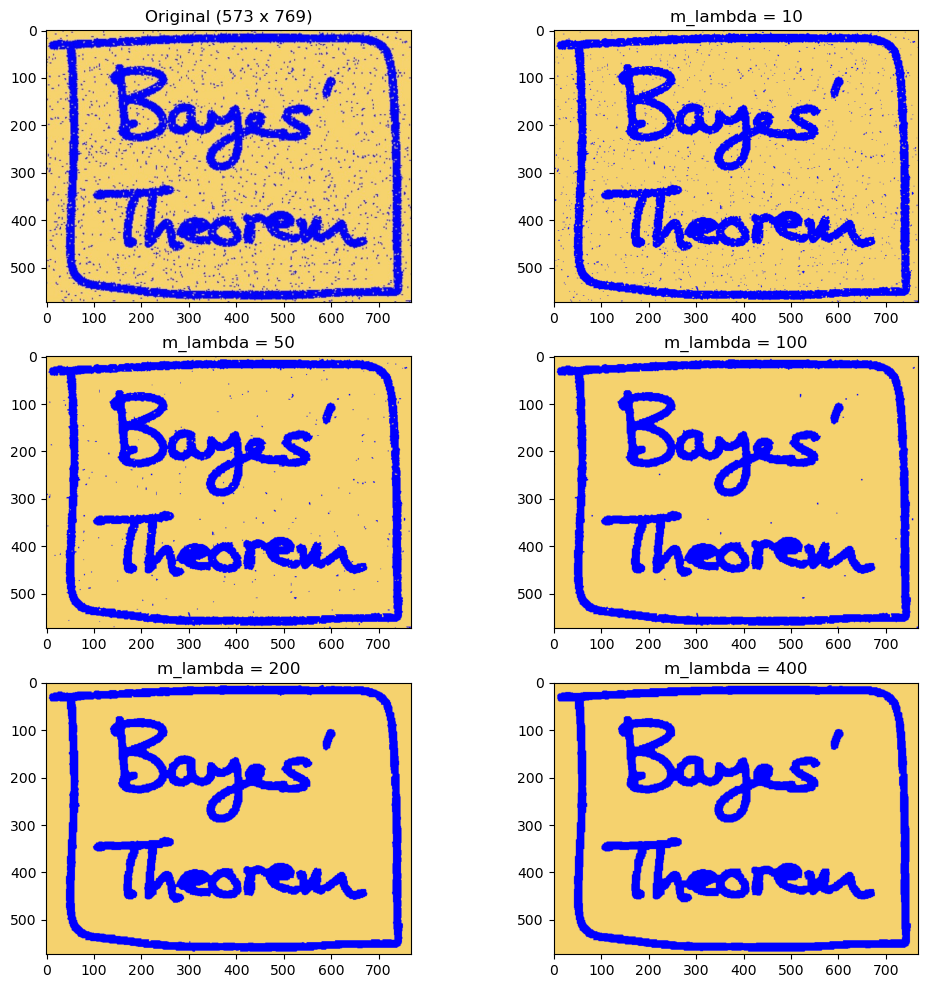

In [3]:
# Some global settings
m_lambdas = [10, 50, 100, 200, 400]; # change this value to change the weight of the smoothness or prior term
SOURCE_COLOR = np.array([0, 0, 255]); # blue = foreground
SINK_COLOR = np.array([245, 210, 110]); # yellow = background

# Read the input image
img = Image.open('media/bayes_in.jpg')
img = np.asarray(img)
print(img.shape)

# Display the original image
_, ax = plt.subplots(3, 2, figsize=(12, 12))
ax[0][0].imshow(np.array(img), cmap='gray')
ax[0][0].title.set_text('Original (%d x %d)' %(np.array(img).shape[0], np.array(img).shape[1]))

for n in range(len(m_lambdas)):
    m_lambda = m_lambdas[n]
    
    # Construct a graph
    edges, edge_weights, unary = construct_graph(img, m_lambda)
    pairwise = (1 - np.eye(2)) * 0.5
    
    # Apply graphcut to get labels
    labels = gco.cut_general_graph(edges, edge_weights, unary, pairwise, n_iter=-1, algorithm="swap")
    labels = labels.reshape(img.shape[:2])
    labels = labels[..., np.newaxis]
    
    # Reconstruct the output image from labels
    img_bg = np.full_like(img, SINK_COLOR)
    img_fg = np.full_like(img, SOURCE_COLOR)
    img_out = labels*img_bg + (1-labels)*img_fg
    
    # Display the image
    i = int((n + 1)/2)
    j = int((n + 1)%2)
    ax[i][j].imshow(img_out)
    ax[i][j].title.set_text('m_lambda = %d' %m_lambda)
    

## Part 1: Noise Removal Observations

It can be viewed that by changing the parameter `m_lambda`, the noise removal result is significantly affected. A smaller value of `m_lambda` leaves more noise in the output image while a larger value of `m_lambda` is able to remove noise more throughtly. 

## Part 2: Depth from Rectified Stereo Images

In [ ]:
import cv2 
import math
import numpy as np
import gco
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
%matplotlib inline

def dists(c1, c2):
    dists = np.absolute(c2 - c1)
    dists = np.sum(dists, axis=1)
    return dists/3

def add_weight(unary_cost, node, dists):
    unary_cost[node] = dists
    return unary_cost
    
def add_edge(edges, edge_weights, node, next_node, cost_1, cost_2):
    edges.append([node, next_node])
    edge_weights.append(cost_1)
    return edges, edge_weights
    
def construct_depth_graph(img_left, img_right, m_lambda, n_labels):
    height, width, colors = img_left.shape
    
    idxs = np.arange(height*width).reshape(height, width)
    edges = []
    edge_weights = []
    unary_cost = np.zeros([height*width, n_labels])
    
    trans, grad = calc_epipolar(M)
    
    for x in range(height):
        for y in range(width):
            c = img_left[x, y]
            node = idxs[x, y]

            # data term:
            start_idx = max(0, y-n_labels)
            img_slice = img_right[x, start_idx:y]
            img_slice = np.flip(img_slice, 0) # reverse the slice
            full_disps = dists(c, img_slice)
            unary_cost = add_weight(unary_cost, node, full_disps)
            # print('full_disps', full_disps.shape, np.amax(full_disps), np.amin(full_disps))

            # prior term: start
            if x + 1 < height:
                next_node = idxs[x+1, y] # the right neighbor
                edges, edge_weights = add_edge(edges, edge_weights, node, next_node, m_lambda, m_lambda)
                
            if y + 1 < width:
                next_node = idxs[x, y+1] # the below neighbor
                edges, edge_weights = add_edge(edges, edge_weights, node, next_node, m_lambda, m_lambda)
            # prior term: end
            
    return np.asarray(edges), np.asarray(edge_weights), unary_cost

In [2]:
# Read the input image
img_left = Image.open('media/im2.png')
img_left = np.asarray(img_left)
img_right = Image.open('media/im6.png')
img_right = np.asarray(img_right)
print(img_right.shape)

(375, 450, 3)


In [ ]:
max_depths = [10, 50]
n_depth = 50
m_lambdas = [100, 400]

_, ax = plt.subplots(len(max_depths), len(m_lambdas), figsize=(20, 20))

for i in range(len(max_depths)):
    max_depth = max_depths[i]
    print('max_depth = ', max_depth)
    disparity = np.arange(n_depth)/n_depth*max_depth
    # print(disparity)
    
    pairwise = np.zeros((n_depth, n_depth), dtype=int)
    for i_d in range(pairwise.shape[0]):
        for j_d in range(pairwise.shape[1]):
            pairwise[i_d, j_d] = (disparity[i_d] - disparity[j_d])**2
    # print(pairwise.shape)
    
    for j in range(len(m_lambdas)):
        m_lambda = m_lambdas[j]
        print('m_lambda = ', m_lambda)
        
        # Construct a graph
        edges, edge_weights, unary = construct_depth_graph(img_left, img_right, m_lambda, n_depth)

        # Apply graphcut to get labels
        labels = gco.cut_general_graph(edges, edge_weights, unary, pairwise, n_iter=-1, algorithm="swap")
        labels = labels.reshape(img_left.shape[0], img_left.shape[1], -1)
        
        # Display the image
        ax[i][j].imshow(labels, cmap='gray')
        ax[i][j].title.set_text('max_depth = %d, m_lambda = %d' %(max_depth, m_lambda))

max_depth =  10
m_lambda =  100


(50, 50)


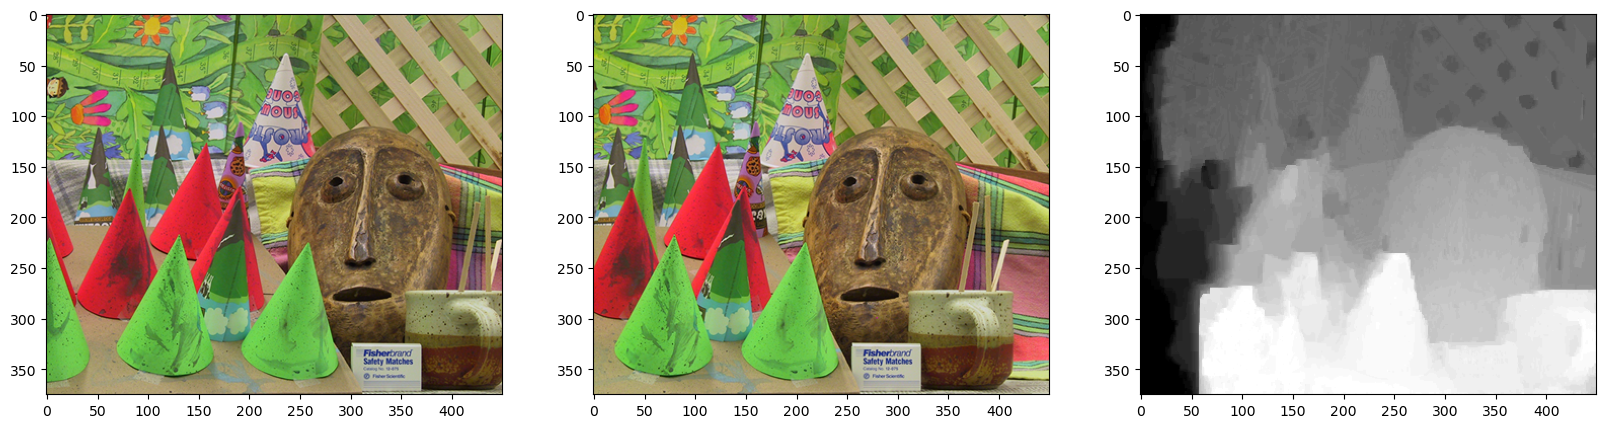

In [4]:
n_depth = 50
m_lambda = 50

disparity = np.arange(n_depth)
# print(disparity)

pairwise = np.zeros((n_depth, n_depth), dtype=int)
for i_d in range(pairwise.shape[0]):
    for j_d in range(pairwise.shape[1]):
        pairwise[i_d, j_d] = abs(disparity[i_d] - disparity[j_d])
print(pairwise.shape)

# Construct a graph
edges, edge_weights, unary = construct_depth_graph(img_left, img_right, m_lambda, n_depth)

# Apply graphcut to get labels
labels = gco.cut_general_graph(edges, edge_weights, unary, pairwise, n_iter=-1, algorithm="swap")
labels = labels.reshape(img_left.shape[0], img_left.shape[1], -1)

# Display the original image
_, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(img_left)
ax[1].imshow(img_right)
ax[2].imshow(labels, cmap='gray')

## Part 2 Observations
By changing the values of `n_depth` and `m_lambda`, the quality of the result varies a lot. From observations, it was found that a larger value of `m_lambda` will result in larger pixel/depth segments, while a smaller value of `m_lambda` will give smaller patches with lots of noise. The `n_depth` controls the number of labels in the graph and the range of the disparity considered for each pixel. 

Meanwhile, the left side of the left eye image could not find a match in the right eye image due occulsions, causing the depth map in this region unknown. On some regions of the image (such as the painting and the wooden fence in the back ground), although the pixels' colors differ greatly from each other, they still belong to the same object (having similar depth values), causing undesired confusion to the algorithm when computing the costs. 

## Part 3: Depth from Stereo

In [1]:
import cv2 
import math
import numpy as np
import gco
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
%matplotlib inline

def calc_epipolar(M):
    K1 = M[:3]
    R1 = M[3:6]
    T1 = M[6]
    K2 = M[7:10]
    R2 = M[10:13]
    T2 = M[13]
    
    trans = np.matmul(np.matmul(np.matmul(K2, R2.transpose()), R1), np.linalg.inv(K1))
    grad = np.matmul(np.matmul(K2, R2.transpose()), (T1 - T2))
    
    return trans, grad

def dists(c1, c2):
    dists = np.absolute(c2 - c1)
    dists = np.sum(dists, axis=1)
    return dists/3

def add_weight(unary_cost, node, dists):
    unary_cost[node] = dists
    return unary_cost
    
def add_edge(edges, edge_weights, node, next_node, cost_1, cost_2):
    edges.append([node, next_node])
    edge_weights.append(cost_1)
    return edges, edge_weights

def project_X(X, img_right, trans, grad, disparity):
    height, width, colors = img_right.shape
    I = np.full((disparity.shape[0], colors), [255, 255, 255])
    
    for i in range(disparity.shape[0]):
        d = disparity[i]
        X_h1 = np.append(X, 1)
        # print('X_h1', X_h1)
        X_h2 = np.matmul(trans, X_h1) + d * grad
        # print('X_h2', X_h2)
        X_2 = X_h2 / X_h2[-1]
        x = int(X_2[0])
        y = int(X_2[1])
        
        if x >= 0 and x < height and y >= 0 and y < width:
            I[i] = img_right[x, y, :]
            # print('x, y, I[i]:', x, y, I[i])

    return I
    
def construct_depth_graph(img_left, img_right, M, m_lambda, disparity):
    height, width, colors = img_left.shape
    n_labels = disparity.shape[0]
    
    idxs = np.arange(height*width).reshape(height, width)
    edges = []
    edge_weights = []
    unary_cost = np.zeros([height*width, n_labels])
    
    trans, grad = calc_epipolar(M)
    
    for x in range(height):
        for y in range(width):
            c = img_left[x, y]
            node = idxs[x, y]

            # data term:
            img_slice = project_X(np.asarray([x,y]), img_right, trans, grad, disparity)
            # img_slice = np.flip(img_slice, 0) # reverse the slice
 
            full_disps = dists(c, img_slice)
            unary_cost = add_weight(unary_cost, node, full_disps)
            # print('full_disps', full_disps.shape, np.amax(full_disps), np.amin(full_disps))

            # prior term: start
            if x + 1 < height:
                next_node = idxs[x+1, y] # the right neighbor
                edges, edge_weights = add_edge(edges, edge_weights, node, next_node, m_lambda, m_lambda)
                
            if y + 1 < width:
                next_node = idxs[x, y+1] # the below neighbor
                edges, edge_weights = add_edge(edges, edge_weights, node, next_node, m_lambda, m_lambda)
            # prior term: end
            
    return np.asarray(edges), np.asarray(edge_weights), unary_cost

In [2]:
# Read the input image
img_left = Image.open('media/test00.jpg')
img_left = np.asarray(img_left)
img_right = Image.open('media/test09.jpg')
img_right = np.asarray(img_right)
print(img_right.shape)

# Load the camera matrices
M = np.loadtxt('cam_matrices.txt')

(540, 960, 3)


In [ ]:
max_depths = [0.1, 1.0, 10]
n_depth = 50
m_lambdas = [0.01, 1, 100]

_, ax = plt.subplots(len(max_depths), len(m_lambdas), figsize=(20, 20))

for i in range(len(max_depths)):
    max_depth = max_depths[i]
    print('max_depth = ', max_depth)
    disparity = np.arange(1, n_depth+1)/n_depth*max_depth
    # print(disparity)
    
    pairwise = np.zeros((n_depth, n_depth), dtype=int)
    for i_d in range(pairwise.shape[0]):
        for j_d in range(pairwise.shape[1]):
            pairwise[i_d, j_d] = (disparity[i_d] - disparity[j_d])**2
    # print(pairwise.shape)
    
    for j in range(len(m_lambdas)):
        m_lambda = m_lambdas[j]
        print('m_lambda = ', m_lambda)
        
        # Construct a graph
        edges, edge_weights, unary = construct_depth_graph(img_left, img_right, M, m_lambda, disparity)

        # Apply graphcut to get labels
        labels = gco.cut_general_graph(edges, edge_weights, unary, pairwise, n_iter=-1, algorithm="swap")
        labels = labels.reshape(img_left.shape[0], img_left.shape[1], -1)
        
        # Display the image
        ax[i][j].imshow(labels, cmap='gray')
        ax[i][j].title.set_text('max_depth = %.3f, m_lambda = %.3f' %(max_depth, m_lambda))

(540, 960, 3)
(50, 50)


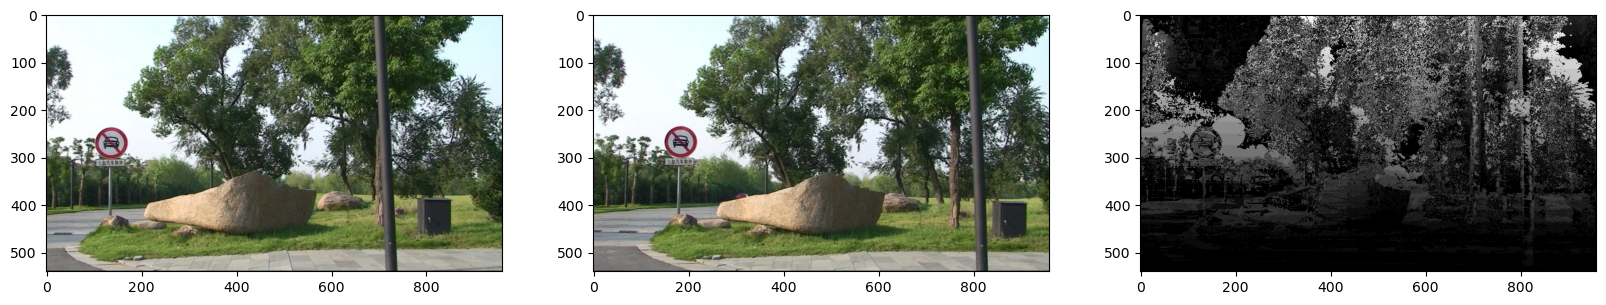

In [9]:
max_depth = 0.1
n_depth = 50
m_lambda = 1

disparity = np.arange(1, n_depth+1)/n_depth*max_depth
# print(disparity)

pairwise = np.zeros((n_depth, n_depth), dtype=int)
for i_d in range(pairwise.shape[0]):
    for j_d in range(pairwise.shape[1]):
        pairwise[i_d, j_d] = abs(disparity[i_d] - disparity[j_d])
print(pairwise.shape)

# Construct a graph
edges, edge_weights, unary = construct_depth_graph(img_left, img_right, M, m_lambda, disparity)

# Apply graphcut to get labels
labels = gco.cut_general_graph(edges, edge_weights, unary, pairwise, n_iter=-1, algorithm="swap")
labels = labels.reshape(img_left.shape[0], img_left.shape[1], -1)

# Display the original image
_, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(img_left)
ax[1].imshow(img_right)
ax[2].imshow(labels, cmap='gray')

## Part 3 Discussion:
Besides the points discussed in Part 2, such as the effect of occulsions, there are more factors to be considered in this set of images. 

On one hand, a large portion of the image is covered by green vegetations having similar color values but different depth (such as tree leaves and the grass). The small difference in pixle color would result in a small cost in the algorithm when these pixels are compared. 

On the other hand, some parts of the sky (such as the top left and right portion) show different colors in the image dispite they are the same object (of the same depth). And the large segment of the road on the bottom and left side of the image with few patterns is another challenge for the algorithm. Since the road looks similar everywhere but winding to afar, different sections of the road should be assigned with different depth values.

## Part 4: Depth from Video -- Basic

In [10]:
import os
import cv2 
import math
import numpy as np
import gco
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
%matplotlib inline

def calc_epipolar(M1, M2):
    K1 = M1[:3]
    R1 = M1[3:6]
    T1 = M1[6]
    
    K2 = M2[:3]
    R2 = M2[3:6]
    T2 = M2[6]
    
    trans = np.matmul(np.matmul(np.matmul(K2, R2.transpose()), R1), np.linalg.inv(K1))
    grad = np.matmul(np.matmul(K2, R2.transpose()), (T1 - T2))
    
    return trans, grad

def dists(c1, c2):
    diffs = c2 - c1
    # l1_dists = np.absolute(diffs)
    # l1_dists = np.sum(l1_dists, axis=1) / 3
    l2_dists = np.power(diffs, 2)
    l2_dists = np.sqrt(np.sum(l2_dists, axis=1))
    return l2_dists #l1_dists

def construct_graph(img_1, img_2, M1, M2, sigma_c, epsilon, disparity):
    H, W, C = img_1.shape
    idxs = np.arange(H*W).reshape(H, W)
    
    # neighbours
    left = idxs[:, :-2].flatten()
    up = idxs[:-2, :].flatten()
    right = idxs[:, 1:-1].flatten()
    down = idxs[1:-1, :].flatten()
    
    # prior term: start
    source = np.concatenate((up, down, left, right))
    target = np.concatenate((down, up, right, left))
    edges = np.stack((source, target), axis=1)
    
    img_vec = img_1.reshape(-1, 3)
    diffs = img_vec[source] - img_vec[target]
    l2_dists = np.power(diffs, 2)
    l2_dists = np.sqrt(np.sum(l2_dists, axis=1))
    
    edge_weights = 1/(l2_dists + epsilon)
    # print('edges:', edges.shape)
    # print('edge_weights:', edge_weights.shape)
    
    # prior term: end
    print('prior term computed')
    
    # data term:
    n_labels = disparity.shape[0]
    trans, grad = calc_epipolar(M1, M2)
    unary_cost = np.zeros((n_labels, H*W))
    
    row = np.tile(np.arange(H), (W, 1)).flatten()
    col = np.tile(np.arange(W), (1, H)).flatten()
    print('col:', col.shape)
    X1_h = np.stack((col, row, np.ones(H*W)), axis=1).transpose()
    print('X1_h:', X1_h.shape)

    for i in range(disparity.shape[0]):
        d = disparity[i]
        
        X2_h = np.matmul(trans, X1_h) + d * grad[:, np.newaxis]
        # print('X2_h', X2_h)
        X2 = X2_h / X2_h[-1, :]
        X2 = X2.astype(int)
        
        x = X2[0, :]
        y = X2[1, :]
        x[x < 0] = 0
        x[x >= H] = H-1
        y[y < 0] = 0
        y[y >= W] = W-1
        I = img_2[x, y]
        unary_cost[i] = dists(img_1[x,y], I)

    unary_cost = sigma_c/(sigma_c + unary_cost)
    print('unary_cost:', unary_cost.shape)
    
    print('data term computed')
    
    return edges, edge_weights, unary_cost.transpose()

In [14]:
N = 10
total_frames = 141
img_start_idx = 0

# Load the camera matrices
cam_matrices = np.loadtxt('Road/cameras.txt', skiprows=2)
cam_matrices = cam_matrices.reshape((total_frames, -1, 3))
mats = cam_matrices[img_start_idx:img_start_idx+N, :, :]
print('mats:', mats.shape)

# Read the input images
imgs = []
for i in range(N):
    filename = 'test{0:04d}'.format(img_start_idx + i) + '.jpg'
    img = Image.open('Road/src/' + filename)
    imgs.append(np.asarray(img))

imgs = np.asarray(imgs)
print('imgs', imgs.shape)

mats: (10, 7, 3)
imgs (10, 540, 960, 3)


Processing image 1
prior term computed
col: (518400,)
X1_h: (3, 518400)
unary_cost: (50, 518400)
data term computed
Processing image 2
prior term computed
col: (518400,)
X1_h: (3, 518400)
unary_cost: (50, 518400)
data term computed
Processing image 3
prior term computed
col: (518400,)
X1_h: (3, 518400)
unary_cost: (50, 518400)
data term computed
Processing image 4
prior term computed
col: (518400,)
X1_h: (3, 518400)
unary_cost: (50, 518400)
data term computed
Processing image 5
prior term computed
col: (518400,)
X1_h: (3, 518400)
unary_cost: (50, 518400)
data term computed
Processing image 6
prior term computed
col: (518400,)
X1_h: (3, 518400)
unary_cost: (50, 518400)
data term computed
Processing image 7
prior term computed
col: (518400,)
X1_h: (3, 518400)
unary_cost: (50, 518400)
data term computed
Processing image 8
prior term computed
col: (518400,)
X1_h: (3, 518400)
unary_cost: (50, 518400)
data term computed
Processing image 9
prior term computed
col: (518400,)
X1_h: (3, 518400)


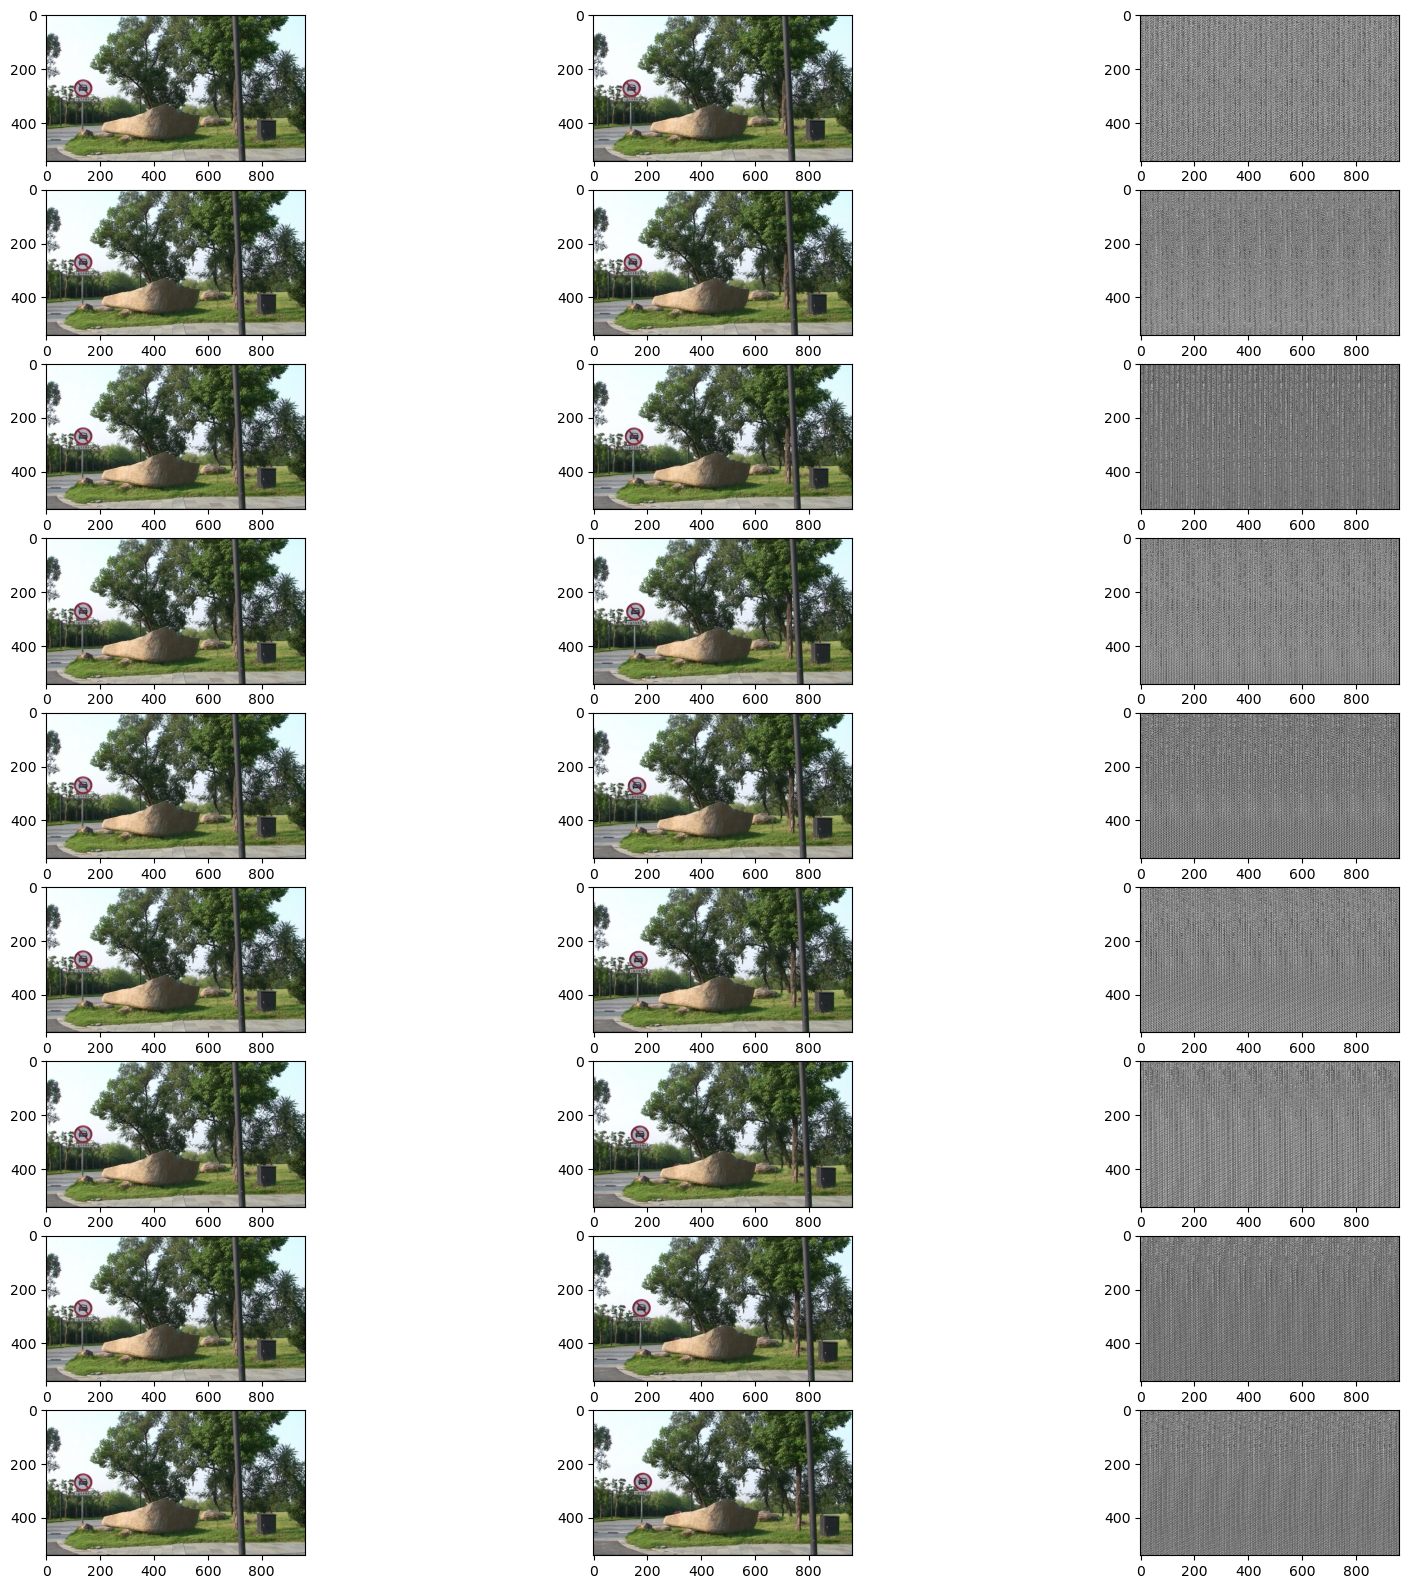

In [15]:
max_depth = 0.1
n_depth = 50
epsilon = 50
sigma_c = 10

# Set disparities
disparity = np.arange(1, n_depth+1)/n_depth*max_depth
w_s = 2 / (disparity[-1] - disparity[0])

# Calculate pairwise weights
eta = 0.05 * (disparity[-1] - disparity[0])
a, b = np.meshgrid(disparity, disparity)
pairwise = np.minimum(np.absolute(a - b), eta)

# Setup a plot
_, ax = plt.subplots(N-1, 3, figsize=(20, 20))

img_1 = imgs[img_start_idx]
M1 = mats[img_start_idx]

for i in range(N-1):
    img_idx = img_start_idx+i+1
    print('Processing image', img_idx)
    img_2 = imgs[img_idx]
    M2 = mats[img_idx]
    
    edges, edge_weights, unary = construct_graph(img_1, img_2, M1, M2, sigma_c, epsilon, disparity)
    
    # Normalize edge weights
    H, W, C = img_1.shape
    N_x = np.full((H, W), 4)
    N_x[:-1, :] = N_x[:-1, :] - 1
    N_x[:, :-1] = N_x[:, :-1] - 1
    N_x = N_x.flatten()
    u_lambda = N_x / np.sum(edge_weights)
    edge_weights = w_s * u_lambda[edges[:, 0]] * edge_weights
    
    # Apply graphcut to get labels
    labels = gco.cut_general_graph(edges, edge_weights, unary, pairwise, n_iter=-1, algorithm="swap")
    labels = labels.reshape(img_1.shape[0], img_1.shape[1], -1)

    # Display the original image
    ax[i][0].imshow(img_1)
    ax[i][1].imshow(img_2)
    ax[i][2].imshow(labels, cmap='gray')

In [ ]:
# Read the input image
img_1 = Image.open('media/test00.jpg')
img_1 = np.asarray(img_1)
img_2 = Image.open('media/test09.jpg')
img_2 = np.asarray(img_2)
print(img_2.shape)

# Load the camera matrices
M = np.loadtxt('cam_matrices.txt')
M = M.reshape(2, -1, 3)

max_depth = 0.01
n_depth = 50
epsilon = 50
sigma_c = 10

# Set disparities
disparity = np.arange(1, n_depth+1)/n_depth*max_depth
w_s = 2 / (disparity[-1] - disparity[0])

# Calculate pairwise weights
eta = 0.05 * (disparity[-1] - disparity[0])
a, b = np.meshgrid(disparity, disparity)
pairwise = np.minimum(np.absolute(a - b), eta)

print('Processing image')
edges, edge_weights, unary = construct_graph(img_1, img_2, M[0], M[1], sigma_c, epsilon, disparity)

# Normalize edge weights
H, W, C = img_1.shape
N_x = np.full((H, W), 4)
N_x[:-1, :] = N_x[:-1, :] - 1
N_x[:, :-1] = N_x[:, :-1] - 1
N_x = N_x.flatten()
u_lambda = N_x / np.sum(edge_weights)
edge_weights = w_s * u_lambda[edges[:, 0]] * edge_weights

# Apply graphcut to get labels
labels = gco.cut_general_graph(edges, edge_weights, unary, pairwise, n_iter=-1, algorithm="swap")
labels = labels.reshape(img_1.shape[0], img_1.shape[1], -1)

# Display the original image
_, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(img_1)
ax[1].imshow(img_2)
ax[2].imshow(labels, cmap='gray')